# Running a multilevel sweep parameter study with PhysiCOOL


## Generating data (optional)
We do not have any data, so we need to generate a dataset. This step could be replaced by loading some target data from a file, though. However, it is important to make sure that the data fits the model output format! 

Therefore, let's create a black box that changes the **speed** and **migration bias** of a model and returns the final y coordinates of the cells. We will try to replicate the behavior of cells that are fully attracted to oxygen, so let's set the migration_bias to 1.

In [18]:
from physicool import optimization as opt
from physicool.updaters import CellUpdater, update_motility_values
from physicool.processing import get_final_y_position

# Compiles the project and creates a black box object for it
# opt.compile_project()    
black_box = opt.PhysiCellBlackBox()

# Define the updater we want to use (change motility data)
new_values = {"speed": 2.0, "migration_bias": 0.9}
updater = CellUpdater(updater_function=update_motility_values,
                     config_path="config/PhysiCell_settings.xml", cell_definition_name="default")

# Assign the updater and processor to the black box
black_box.updater = updater
black_box.processor = get_final_y_position
black_box.version = "1.9.1"

# Run the model with the target values (speed=2.0 bias=0.9)
opt.clean_tmp_files()
target_data = black_box.run(new_values)

In [19]:
import numpy as np
np.savetxt('motility_target.csv', target_data, fmt="%d", delimiter=",")

## Running the multilevel sweep pipeline

Now, we will see if we can identify the parameters that generated these results by running a multilevel parameter sweep. We will start at a random point (speed=3.0, bias=0.6) and explore the parameter space. We can choose the number of points per direction that will be explored (`points_dir`) and the percentage of change per direction in regards to the initial value (`percentage_dir`). We can also select the number of levels to go through (`n_levels`).

(1.698125, 0.8290714285714286)


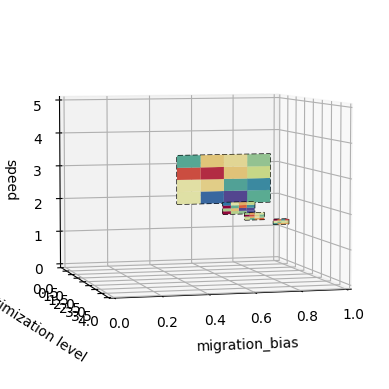

In [25]:
%matplotlib inline
from physicool import optimization as opt
import matplotlib.pyplot as plt

# Create the multilevel sweep
sweeper = opt.MultiLevelSweep(black_box=black_box, 
                              target_data=target_data, 
                              n_levels=4,
                              points_dir=5, 
                              percentage_dir=0.3, 
                              parameters=["speed", "migration_bias"])

# Be sure that we don't select values that don't make sense to PhysiCell
sweeper.param_bounds = [(0.0, None), (0.0, 1.0)]

# Run the multilevel sweep
point = sweeper.run_sweep(initial_point=(2.5, 0.75))
plt.savefig("sweep.svg", format="svg")
print(point)

We can now compare the values that our sweeper identified and compare them with those that were used to create the target dataset (speed=2.0, bias=0.9).